# Linear Cascaded Control

**NOTE** - completing this exercise without looking at the solution could take a few hours. Be prepared and good luck!

<img src="Drone2.png" width="300" height="300">

In this lesson we will be working with a simplified model of the 2D drone you worked with in the first lesson. We will be directly setting the vehicle's collective thrust through $u_1$ and the moment about the x axis, $M_x$ through $u_2$. We will ignore propeller rotation rates as well as the yaw-inducing moment $M_z$.

The state of this 2D drone can be described by the following vector: 

$$X = [z , y, \phi, \dot{z}, \dot{y},\dot{\phi}]$$


In [9]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import trajectories
import simulate
import plotting

pylab.rcParams['figure.figsize'] = 10, 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### TODO 1 - Review Simplified `Drone2D` class
Walk through this code to refamiliarize youself with how state is represented, how controls are set, and what the underlying dynamics are.

In [10]:
class Drone2D:
    """
    Simulates the dynamics of a drone confined to 
    motion in the y-z plane. 
    """
    def __init__(self,
                 I_x = 0.1, # moment of inertia around the x-axis
                 m = 0.2,   # mass of the vehicle 
                ):
        
        self.I_x = I_x
        self.m = m
        
        self.u1 = 0.0 # collective thrust
        self.u2 = 0.0 # moment about the x axis
        self.g = 9.81
        
        # z, y, phi, z_dot, y_dot, phi_dot
        self.X = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
    
    @property
    def y_dot_dot(self):
        phi = self.X[2]
        return self.u1 / self.m * np.sin(phi)
    
    @property
    def z_dot_dot(self):
        phi = self.X[2]
        return self.g - self.u1*np.cos(phi)/self.m
    
    @property
    def phi_dot_dot(self):
        return self.u2 / self.I_x
    
    def advance_state(self, dt):
        
        X_dot = np.array([self.X[3], 
                        self.X[4],
                        self.X[5], 
                        self.z_dot_dot,
                        self.y_dot_dot, 
                        self.phi_dot_dot])
        
        
        # Change in state will be 
        self.X = self.X + X_dot * dt
        return self.X 
    
    def set_controls(self, u1, u2):
        self.u1 = u1
        self.u2 = u2

### Linear Cascading Controller

In this section, you will create the controller described in class. The schematic description of the cascading controller looks like this:
<img src="CascadingController2.png" width="800" >

The controller architecture uses three **PD** controllers to control the drone (note that you will not need an I term for the controllers used in this exercise). 

One PD controller is used to generate the thrust and control the altitude while two PD controllers are used to control the lateral motion. The first receives the desired lateral position information containing $y$ , $\dot{y}$ and (optionally) $\ddot{y}$. Using this information as well as the current vehicle state, it outputs the commanded $\phi$ roll angle. 

The second PD controller is used to set a torque value $M_x$ to achieve the desired angle. In most cases, the inner controller responsible for roll angle operates at a higher frequency than the ones that are used to control the position. 

#### TODO - Implement 2D controller with LINEAR control equations.

The linear equations of motion are shown below.

$$\begin{align}
\ddot{z} &= g - \frac{u_1}{m}
\\
\\
\ddot{y} &= g \phi
\\
\\
\ddot{\phi} &= \frac{u_2}{I_x}
\end{align}$$

These equations can be solved for $u_1$, $\phi_{\text{command}}$, and $u_2$.

$$\begin{align}
u_1 &= m(g - \bar{u_1})
\\
\\
\phi_{\text{command}} &= \frac{\ddot{y}_{\text{target}}}{g}
\\
\\
u_2 &= I_x \bar{u}_2 
\end{align}$$

The first equation will be useful when implementing `altitude_controller`, the second when implementing `lateral_controller`, and the third when implementing `attitude_controller`.

Note that $\ddot{y}_{\text{target}}$ is like $\bar{u}_1$ or $\bar{u}_2$. It comes from PD control on the controller's inputs.

In [11]:
class LinearCascadingController:
    
    def __init__(self,
                 m,   # needed to convert u1_bar to u1
                 I_x, # needed to convert u2_bar to u2
                 z_k_p=1.0,   
                 z_k_d=1.0,   
                 y_k_p=1.0,
                 y_k_d=1.0,
                 phi_k_p=1.0,
                 phi_k_d=1.0):
        
        self.z_k_p = z_k_p
        self.z_k_d = z_k_d   
        self.y_k_p = y_k_p
        self.y_k_d = y_k_d
        self.phi_k_p = phi_k_p
        self.phi_k_d = phi_k_d
        
        self.g = 9.81
        self.I_x = I_x
        self.m = m

    def altitude_controller(self, 
                    z_target, 
                    z_actual, 
                    z_dot_target, 
                    z_dot_actual,
                    z_dot_dot_target,
                    phi_actual, # unused parameter. Ignore for now.
                    ):
        """
        A PD controller which commands a thrust (u_1) 
        for the vehicle. 
        """
        
        # TODO (recommended to do AFTER attitude)
        #   Implement feedforward PD control to calculate
        #   u_1_bar and then use the linear math from above
        #   to transform u_1_bar into u_1 and then return u_1
        
        err = z_target - z_actual
        err_dot = z_dot_target - z_dot_actual
        u_1_bar = self.z_k_p * err + self.z_k_d * err_dot + z_dot_dot_target
        u_1 = self.m * (self.g - u_1_bar) 
        return u_1

    
    def lateral_controller(self, 
                        y_target, 
                        y_actual, 
                        y_dot_target, 
                        y_dot_actual,
                        u_1=None, # unused parameter. Ignore for now.
                        y_dot_dot_ff=0.0,
                        ):
        """
        A PD controller which commands a target roll 
        angle (phi_commanded).
        """
        
        # TODO (recommended to do AFTER attitude)
        #   Implement feedforward PD control to calculate
        #   y_dot_dot_target and then use the linear math from above
        #   to transform y_dot_dot_target into phi_commanded
        #   and then return phi_commanded
        err = y_target - y_actual
        err_dot = y_dot_target - y_dot_actual
        y_dot_dot_bar = self.y_k_p * err + self.y_k_d * err_dot + y_dot_dot_ff
        phi_commanded = y_dot_dot_bar / self.g
        # print("phi_commanded = ", phi_commanded)
        
        return phi_commanded 

    def attitude_controller(self, 
                            phi_target, 
                            phi_actual, 
                            phi_dot_actual,
                            phi_dot_target=0.0
                           ):
        """
        A PD controller which commands a moment (u_2)
        about the x axis for the vehicle.
        """
        
        # TODO (recommended to do FIRST)
        #   Implement PD control to calculate u_2_bar
        #   and then use the linear math from above to
        #   transform u_2_bar into u_2 and then return u_2
        err = phi_target - phi_actual
        err_dot = phi_dot_target - phi_dot_actual
        u_2_bar = self.phi_k_p * err + self.phi_k_d * err_dot
        u_2 = self.I_x * u_2_bar
        # print("u_2 = ", u_2)
        
        return u_2

The flight path we'll use to test our controller is a figure 8 described as follows:
$$
\begin{align}
z & = a_z \sin{\omega_z t} \\
y & = a_y \cos{\omega_y t}
\end{align}
$$

where $\omega_y = \omega_z / 2$. 

> NOTE - you can find the code that generates this trajectory in the file called `trajectories.py`, which you can access by clicking on the Jupyter logo in the top left corner of this notebook.

phi_commanded =  -0.0254841997961264
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025482925086926532
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02547910108684779
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025472728178439992
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025463806999243666
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02545233844172624
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025438323653192783
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014819788458189367
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01461168856405991
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014402126928617228
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014191124516235075
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01397870243542134
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013764881936706384
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.009442996175860986
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.009679268376156985
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.009914572270400938
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.010148884318984683
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.010382181081523481
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.010614439219200973
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.010845635497103993
u_2 =  0.0
u_2 =  0.0
u_2 =  0

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023560453473545916
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02365642645615248
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023750032869301822
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023841263348685308
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023930108767680775
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02401656023826554
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0241006

phi_commanded =  0.022251917419321383
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02212656542414068
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021998999905542858
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021869233625077544
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02173727956445676
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02160315092425627
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021466861122594983
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0


phi_commanded =  0.004850070481747445
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.004599597825320409
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.004348665028907771
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.004097297195620219
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0038455194720891737
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0035933570459511345
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0033408351433279384
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =

u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01677891661325609
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.016969922936100904
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.017159231601804374
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.017346823672083192
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.017532680380380843
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01771678313374501
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.017899113514687568
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2

phi_commanded =  -0.025482385978382843
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025484152379515488
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02548336936699191
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02548003701914405
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025474155669337237
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02546572590593688
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02545474857224957
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =

phi_commanded =  -0.020468145349629013
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02031527161441525
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02016036555612822
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.020003442671442658
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01984451865879496
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.019683609416812724
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01952073104272424
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =

phi_commanded =  -6.14504988510605e-05
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.00019344056051913013
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0004483122682546535
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0007031391271993708
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0009578956446837795
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0012125563350752788
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0014670957223277316
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0


u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02008495325556803
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.020240833709158402
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02039468928638236
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02054650459565443
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.020696264449495856
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02084395386605397
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_co

phi_commanded =  0.0254840931087932
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025483555945814803
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025480469428846925
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025474833866662185
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025466649823037597
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02545591811669815
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025442639821234934
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0


phi_commanded =  0.0178049193170286
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0176216688557318
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.017436655537167587
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.017249897869916264
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.017061414537061354
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.016871224394320546
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.01667934646815938
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0027126431321469113
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.002965948070716766
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.003218956298279619
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.003471642504100356
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0037239814096586533
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.00397594777117782
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.00422751

phi_commanded =  -0.019751657397820855
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01991173201721037
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02006981468329621
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02022588958161841
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02037994109857243
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.020531953822971148
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.020681912547586563
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =

phi_commanded =  -0.025281635672912535
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025248297573360584
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02521243365487335
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025174047505247765
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025133142964602676
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02508972412499471
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025043795330008892
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014899664569720382
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014692134090925865
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014483133823113746
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014272684674499015
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014060807698241513
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013847524090339784
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013632855187510643
u_2 =  0.0
u_2 =  0.0
u

phi_commanded =  0.008395929444000657
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008636167984888483
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008875542570629984
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.009114029254388362
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.009351604178151814
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.00958824357512025
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.009823923772082912
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023321986696853272
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023423566468950417
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023522802966712046
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023619686262600498
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023714206664490485
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023806354716638705
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02389

phi_commanded =  0.02138207732459086
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021242327695627748
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021100453001663088
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02095646743572455
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02081038540200988
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02066222151444557
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.020511990595225234
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.003942685662026736
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0036906686422434848
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0034382824110028827
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.003185552216816223
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0029325033426042084
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0026791611031683907
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_comma

phi_commanded =  -0.01689644538095214
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.017086411143760884
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01727466759604367
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.017461195904779892
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.017645977409830742
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.017828993625806467
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01801022624391514
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 

phi_commanded =  -0.025345883440971245
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025318095449689673
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025287774656950653
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025254924096021345
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025219547053244893
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025181647067711546
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025141227930904727
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u

phi_commanded =  -0.014523556502509007
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01431338516099608
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014101781920197096
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013888767948726474
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013674364556326675
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013458593191736987
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013241475440547207
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_

phi_commanded =  0.007379777327951099
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.00762337572150059
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.007866211478809188
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008108260306787513
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008349497991069606
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008589900398435999
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008829443479227294
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

phi_commanded =  0.023197764931594277
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023302126607886154
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02340415715858636
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023503846376642542
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023601184289227202
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023696161158735636
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023788767483759833
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.022797239483815963
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02268217907558459
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.022564849560803162
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.022445262677019805
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.022323430387608163
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.022199364880570237
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded 

phi_commanded =  0.00867385601095274
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008433751695704619
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008192803674869444
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.007951036052688987
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0077084730153976115
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.00746513882880201
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.007221057835854364
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.011606425802119257
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.011832764645307015
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.012057919748446205
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.012281868587205222
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01250458875792648
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.012726057979867018
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0129462540

u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024286686878725303
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024362688089697947
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024436252077380115
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024507371482490898
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024576039190303517
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02464224833135688
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024705992282142986
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_

phi_commanded =  -0.021826592437130688
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.021693930254836007
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02155909782959087
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02142210864992037
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02128297642010933
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.021141715058831768
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02099833869775803
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =

phi_commanded =  -0.005268521194233523
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0050188754013787305
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.00476872752435436
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.004518102587748231
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.004267025663873167
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0040155218702580715
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.003763616367135901
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0


phi_commanded =  0.01400684368670871
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.01421907944664696
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.014429892741565297
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.01463926248187513
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.014847167722399593
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.015053587664469468
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.015258501658003283
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0


phi_commanded =  0.025031747655788184
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025078312344198328
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025122368218855804
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02516391087244709
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02520293614907931
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025239440144695834
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025273419207466973
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0

phi_commanded =  0.01844597988985887
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.01826918691824049
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.018090566312179916
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.01791013594073588
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.017727913854014298
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.01754391828136307
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.01735816762954791
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_

u_2 =  0.0
phi_commanded =  0.0002335088542927305
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -2.1380852123017823e-05
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0002762684196158041
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0005311283494430737
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0007859351456267591
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0010406633175046006
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0012952873822794878
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.017574909025390148
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01775860835220099
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.017940531122429812
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0181206591366721
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0182989743750695
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01847545899911201
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
ph

phi_commanded =  -0.025482832541482637
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025478917626646485
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025472453821834492
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025463441773680377
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025451882383742026
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02543777680841131
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02542112645879839
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014183572782822205
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013971100461245703
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013757230482263075
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013541984241251517
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0133253832712679
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.013107449240895214
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

phi_commanded =  0.011312896705215281
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.011540728312340617
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.01176740539449216
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.011992905275080618
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.012217205395283457
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.012440283316301027
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.012662116721601634
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

phi_commanded =  0.024340951122236706
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02441522096722005
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02448704833356705
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02455642603572693
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02462334713321144
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.024687804931288998
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.024749792981654507
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021864565035680655
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021732533190508916
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02159832724058082
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021461960611749178
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021323446946019647
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021182800100185393
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021040034144441253
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

u_2 =  0.0
phi_commanded =  0.002825779486386131
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0025723212118114384
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.00231860560433715
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.002064658045464084
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0018105039398971063
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.0015561687130043861
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.001301677808272779
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 = 

phi_commanded =  -0.015605497522284417
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.015806226683196072
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.016005374602182976
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.016202921356651002
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01639884718418536
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01659313248452703
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01678575782153441
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02468169653863584
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024743923029540142
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02480367415872394
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024860943948733418
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024915726670345778
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024968016843142624
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025017809236058054
u_2 =  0.0
u_2 =  0.0
u_2

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.021745360415510572
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.021611363540654665
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.021475204682754573
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02133689746303051
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02119645571762296
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.021053893496208887
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

phi_commanded =  -0.005364678572463599
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.005115233128092989
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.004865275960004938
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0046148320737088985
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.00436392652340575
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.004112584409480321
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0038608308759910904
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0


phi_commanded =  0.015383617848527167
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.015586057651439332
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.01578693823795584
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.015986239512147653
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.016183941536079268
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.016380024531802727
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.016574468883336444
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

phi_commanded =  0.025417159534419483
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02543436435780195
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025449024748280983
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025461139239243136
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025470706618764712
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025477725929732922
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.025482196469941674
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.019854233058610872
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.019693443998782003
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.019530684823003398
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.019365971813569208
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.019199321448233397
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.019030750398561752
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.01886

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0009424169342718434
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0011970841750795996
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0014516316605704775
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0017060339260232646
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.0019602655212446235
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.002214301013114384
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.002468114988130

phi_commanded =  -0.018407600880426412
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.018582952255170954
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.018756444606646966
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.018928060578822223
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.019097783003376053
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.019265594901416376
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01943147948517897
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_

phi_commanded =  -0.025415365959275477
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025432816064303598
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02544772189131828
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025460081949152835
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02546989500131725
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02547716006612184
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.025481876416775493
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 

u_2 =  0.0
phi_commanded =  -0.015302964975784868
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.015098381961176133
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014892288516846928
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.01468470526021588
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014475652957741341
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014265152522843669
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.014053225013813633
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_

phi_commanded =  0.007435513305537624
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.007678939557845708
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.00792159761535247
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008163463202745302
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008404512123989823
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008644720264749748
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008884063594800302
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.021529421559678952
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02166472525116753
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02179786162135036
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02192881735137421
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.022057579340535597
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02218413470759096
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  

u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023707542999414223
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023612853736589775
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023515802263287214
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02341639828845609
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.02331465175638834
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023210572845723317
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.023104171968429843
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.009807145003697884
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.009571395605062195
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.009334688691877976
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.009097047944110086
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008858497135143587
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008619060129405153
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  0.008378760879976363
u_2 =  0

phi_commanded =  -0.00814017445126648
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.008381303178400157
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.008621593446853421
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.008861021218184991
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.009099562540237603
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.009337193549533482
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.009573890473661952
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_

u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024063378502384405
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024146093914504993
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024226393771238322
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.02430427003945274
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024379714928470436
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024452720890846623
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
u_2 =  0.0
phi_commanded =  -0.024523280623124886
u_

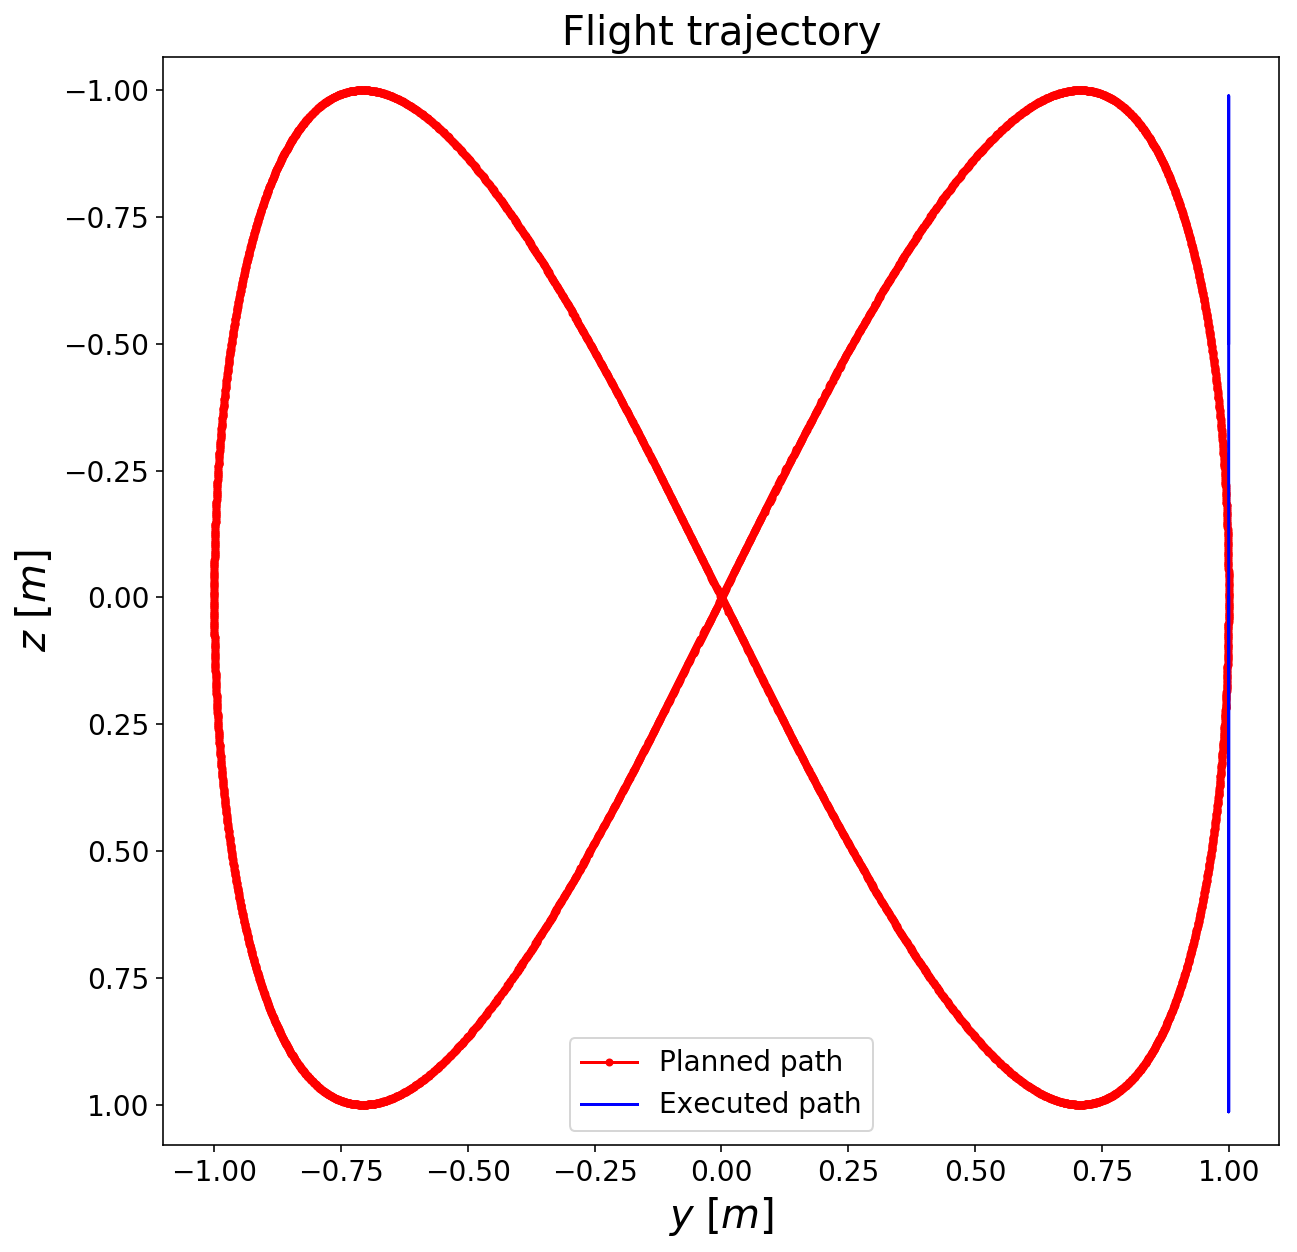

In [12]:
# TESTING CELL 
# 
# Note - this cell will only give nice output when your code
#  is working AND you've tuned your parameters correctly.
#  you might find it helpful to come up with a strategy
#  for first testing the inner loop controller and THEN 
#  testing the outer loop.
#
# Run this cell when you think your controller is ready!
#
# You'll have to tune the controller gains to get good results.

#### CONTROLLER GAINS (TUNE THESE) ######

# parameters from my tuning
# z_k_p   = 1.0  
# z_k_d   = 1.0  
# y_k_p   = .05
# y_k_d   = 10
# phi_k_p = 20.0
# phi_k_d = 20.0

# no PD control
z_k_p   = 0.0  
z_k_d   = 0.0  
y_k_p   = 0.0
y_k_d   = 0.0
phi_k_p = 0.0
phi_k_d = 0.0

#########################################

drone = Drone2D()

# INSTANTIATE CONTROLLER
linear_controller = LinearCascadingController(
    drone.m,
    drone.I_x,
    z_k_p=z_k_p,   
    z_k_d=z_k_d,   
    y_k_p=y_k_p,
    y_k_d=y_k_d,
    phi_k_p=phi_k_p,
    phi_k_d=phi_k_d
)

# TRAJECTORY PARAMETERS (you don't need to change these)
total_time = 100.0  
omega_z = 1.0       # angular frequency of figure 8

# GENERATE FIGURE 8
z_traj, y_traj, t = trajectories.figure_8(omega_z, total_time, dt=0.02)
z_path, z_dot_path, z_dot_dot_path = z_traj
y_path, y_dot_path, y_dot_dot_path = y_traj

# SIMULATE MOTION
linear_history     = simulate.zy_flight(z_traj, 
                                        y_traj,
                                        t, 
                                        linear_controller,
                                        inner_loop_speed_up=10)
# PLOT RESULTS
plotting.plot_zy_flight_path(z_path, y_path, linear_history)

If everything is working correctly you should see a blue figure 8 that (nearly) overlaps with a red figure 8.

[Solution](/notebooks/Linear%20Controller%20Solution.ipynb)